# Wisdom of Polarized Crowds

### Workbench

In [1]:
import numpy as np
import pickle
import pandas as pd
from scipy.stats import pearsonr
import glob
import statsmodels.formula.api as sm

In [2]:
import rpy2
%load_ext rpy2.ipython

In [3]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from matplotlib.ticker import NullFormatter,MaxNLocator
import matplotlib.gridspec as gridspec

In [4]:
pd.set_option('display.max.column',None)

### User Alignment

In [5]:
user_align=pickle.load(open('Data/user_alignments.pkl','rb'), encoding='latin1')
user_align=pd.DataFrame(list(user_align.items()),columns=['user','align'])

/home/bill10/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/bill10/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


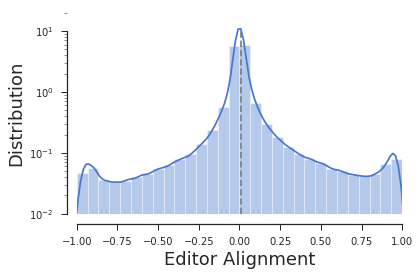

In [6]:
sns.set(style="ticks", palette="muted", color_codes=True)
sns.distplot(user_align['align'], bins=30, norm_hist=False, hist_kws={'log':True, 'edgecolor':"w", 'lw':1},kde_kws={'bw':0.02});
plt.plot([user_align['align'].mean()]*2,[1e-2,10],'--', color='grey')
plt.xlim([-1,1]);
plt.ylim([1e-2,20]);
plt.xlabel('Editor Alignment', fontsize=18)
plt.ylabel('Distribution', fontsize=18);
sns.despine(offset=10,trim=True);
plt.tight_layout();
# plt.savefig('alignment_distribution.pdf');

### User Previous Edits

In [6]:
user_info2=pd.read_csv("Data/user_edits.tsv",sep='\t')
df=pd.merge(user_align,user_info2, left_on='user',right_on='name')

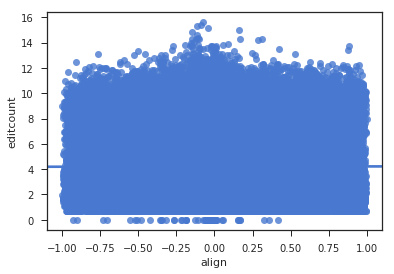

In [8]:
sns.regplot(df['align'],np.log(df['editcount']+1));

In [9]:
pearsonr(df['align'],np.log(df['editcount']+1))

(0.0011774645327912252, 0.6461219837427921)

### Liberal Articles

In [7]:
liberal_pages=pd.read_csv('Data/liberal_pages.tsv',sep='\t',parse_dates=[1])
liberal_pages['time']=pd.to_datetime(liberal_pages['time'])
liberal_pages=liberal_pages.sort_values('time')

liberal_page_stats=liberal_pages.groupby('title').agg({'title':len, 'user':lambda x: x.nunique(), 'byte':'last'})
liberal_page_stats.columns=['edits', 'editors', 'length']
liberal_page_stats=liberal_page_stats.reset_index()
liberal_page_stats['short']=liberal_page_stats['title'].str.lower().str.replace(' ','')
liberal_page_stats=liberal_page_stats.sort_values('length').drop_duplicates(subset='short', keep='last')

liberal_pages['byte']=liberal_pages[['title','byte']].groupby('title').diff()['byte'].fillna(liberal_pages['byte'])
liberal_pages=liberal_pages[liberal_pages['byte']>0]
liberal_pages=liberal_pages.groupby(['title','user']).sum().reset_index()

liberal_pages=liberal_pages.merge(user_align, how ='inner', on='user')
liberal_pages=liberal_pages.merge(user_info2, how='inner', left_on='user', right_on='name')
liberal_pages=liberal_pages.dropna()
liberal_pages=liberal_pages.groupby('title').agg({'align':[np.mean, lambda x: np.var(x)], 'user':lambda x: x.nunique(), 'title':len, 'editcount':np.mean})
liberal_pages.columns=['ave_align','var_align','peditors','pedits', 'editscount']
liberal_pages=liberal_pages.reset_index()

liberal_pages=liberal_pages.merge(liberal_page_stats, how='inner', on='title')

liberal_quality=pd.read_csv("Data/liberal_quality.tsv",sep='\t',header=None, names=['title','quality'])
liberal_quality['short']=liberal_quality.title.str.replace(' ','')
liberal_pages=liberal_pages.merge(liberal_quality, how='inner', on='short')

liberal_pages=liberal_pages.dropna()

In [8]:
liberal_page_stats.shape, liberal_pages.shape

((10038, 5), (6167, 12))

In [9]:
liberal_quality['quality'].value_counts()

Start    2545
C        1630
Stub     1557
GA        377
B         212
FA         91
Name: quality, dtype: int64

In [10]:
liberal_page_stats.describe()

,edits,editors,length
count,10038.000000,10038.000000,10038.000000
mean,154.751046,74.784917,8644.557482
std,686.060364,281.532331,14279.521972
min,1.000000,1.000000,21.000000
25%,16.000000,9.000000,2839.000000
50%,34.000000,22.000000,4708.500000
75%,79.000000,44.000000,8519.750000
max,24489.000000,6566.000000,222398.000000


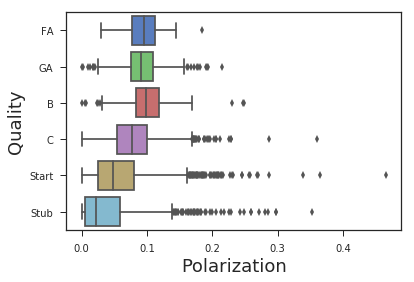

In [16]:
sns.boxplot(x='var_align', y='quality',data=liberal_pages, order=['Stub','Start','C','B','GA','FA'][-1::-1], orient='h');
plt.xlabel('Polarization', fontsize=18);
plt.ylabel('Quality', fontsize=18);

In [17]:
%%R -i liberal_pages
library(MASS)

liberal_pages$quality=factor(liberal_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~ abs(ave_align) + var_align + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = liberal_pages, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

ctable <- cbind(ctable, "p value" = p, "OR" = exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + scale(log(editors)) + 
    scale(log(length)) + scale(log(edits)) + scale(log(editscount)), 
    data = liberal_pages, Hess = TRUE)

Coefficients:
                           Value Std. Error t value
abs(ave_align)         -1.577916    0.37609 -4.1956
var_align               2.755338    0.71916  3.8313
scale(log(editors))    -0.814590    0.12035 -6.7683
scale(log(length))      3.408269    0.07332 46.4859
scale(log(edits))       1.173300    0.13611  8.6202
scale(log(editscount))  0.007256    0.03123  0.2323

Intercepts:
           Value    Std. Error t value 
Stub|Start  -2.9617   0.0834   -35.5100
Start|C      1.2238   0.0748    16.3705
C|B          5.9281   0.1278    46.3851
B|GA         6.8956   0.1386    49.7593
GA|FA       10.2832   0.2181    47.1567

Residual Deviance: 8867.297 
AIC: 8889.297 
                              Value Std. Error     t value       p value
abs(ave_align)         -1.577915601 0.37608878  -4.1955934

### Conservative Articles

In [11]:
conservative_pages=pd.read_csv('Data/conservative_pages.tsv',sep='\t',parse_dates=[1])
conservative_pages['time']=pd.to_datetime(conservative_pages['time'])
conservative_pages=conservative_pages.sort_values('time')

conservative_page_stats=conservative_pages.groupby('title').agg({'title':len, 'user':lambda x: x.nunique(), 'byte':'last'})
conservative_page_stats.columns=['edits','editors', 'length']
conservative_page_stats=conservative_page_stats.reset_index()
conservative_page_stats['short']=conservative_page_stats['title'].str.lower().str.replace(' ','')
conservative_page_stats=conservative_page_stats.sort_values('length').drop_duplicates(subset='short', keep='last')

conservative_pages['byte']=conservative_pages[['title','byte']].groupby('title').diff()['byte'].fillna(conservative_pages['byte'])
conservative_pages=conservative_pages[conservative_pages['byte']>0]
conservative_pages=conservative_pages.groupby(['title','user']).sum().reset_index()

conservative_pages=conservative_pages.merge(user_align,on='user')
conservative_pages=conservative_pages.merge(user_info2, how='inner', left_on='user', right_on='name')
conservative_pages=conservative_pages.dropna()
conservative_pages=conservative_pages.groupby('title').agg({'align':[np.mean, lambda x: np.var(x)], 'user':lambda x: x.nunique(), 'title':len, 'editcount':np.mean})
conservative_pages.columns=['ave_align','var_align','peditors','pedits', 'editscount']
conservative_pages=conservative_pages.reset_index()

conservative_pages=conservative_pages.merge(conservative_page_stats, how='inner', on='title')

conservative_quality=pd.read_csv('Data/conservative_quality.tsv',sep='\t',header=None, names=['title','quality'])
conservative_quality['short']=conservative_quality.title.str.replace(' ','')
conservative_pages=conservative_pages.merge(conservative_quality, how='inner', on='short')

conservative_pages=conservative_pages.dropna()

In [12]:
conservative_page_stats.shape, conservative_pages.shape

((10909, 5), (6403, 12))

In [13]:
conservative_quality['quality'].value_counts()

Start    2464
C        1911
Stub     1393
GA        494
B         273
FA        124
Name: quality, dtype: int64

In [14]:
conservative_page_stats.describe()

,edits,editors,length
count,10909.000000,10909.000000,10909.000000
mean,177.182418,79.580255,9448.811440
std,808.058741,294.429830,15012.707384
min,1.000000,1.000000,45.000000
25%,15.000000,8.000000,3006.000000
50%,37.000000,23.000000,5181.000000
75%,93.000000,49.000000,9705.000000
max,45741.000000,14417.000000,256674.000000


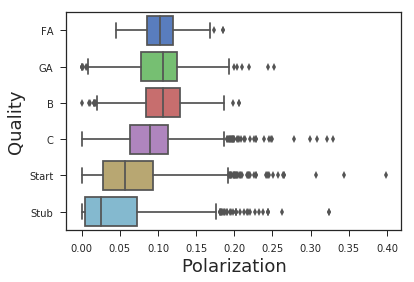

In [24]:
sns.boxplot(x='var_align', y='quality',data=conservative_pages, order=['Stub','Start','C','B','GA','FA'][-1::-1], orient='h');
plt.xlabel('Polarization', fontsize=18);
plt.ylabel('Quality', fontsize=18);

In [15]:
%%R -i conservative_pages
library(MASS)

conservative_pages$quality=factor(conservative_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~ abs(ave_align) + var_align + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = conservative_pages, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

ctable <- cbind(ctable, "p value" = p, "OR" = exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + scale(log(editors)) + 
    scale(log(length)) + scale(log(edits)) + scale(log(editscount)), 
    data = conservative_pages, Hess = TRUE)

Coefficients:
                          Value Std. Error t value
abs(ave_align)         -0.64634    0.40953  -1.578
var_align               2.91860    0.66453   4.392
scale(log(editors))    -0.96836    0.12591  -7.691
scale(log(length))      3.59318    0.07198  49.919
scale(log(edits))       1.19607    0.14045   8.516
scale(log(editscount))  0.08746    0.03015   2.901

Intercepts:
           Value    Std. Error t value 
Stub|Start  -3.3049   0.0822   -40.2175
Start|C      0.8150   0.0698    11.6710
C|B          5.3448   0.1113    48.0319
B|GA         6.2714   0.1201    52.2310
GA|FA        9.5122   0.1884    50.4997

Residual Deviance: 9558.07 
AIC: 9580.07 
                             Value Std. Error    t value      p value
abs(ave_align)         -0.64633925 0.40953470  -1.578228 1.145132

### Science Articles

In [16]:
sci_pages=pd.read_csv('Data/science_pages.tsv',sep='\t',parse_dates=[1])
sci_pages=sci_pages.sort_values('time')

sci_page_stats=sci_pages.groupby('title').agg({'title':len, 'user':lambda x: x.nunique(), 'byte':sum})

sci_page_stats.columns=['edits','editors', 'length']
sci_page_stats=sci_page_stats.reset_index()
sci_page_stats['short']=sci_page_stats['title'].str.lower().str.replace(' ','')
sci_page_stats=sci_page_stats.sort_values('length').drop_duplicates(subset='short', keep='last')

sci_pages=sci_pages[sci_pages['byte']>0]
sci_pages=sci_pages.groupby(['title','user']).sum().reset_index()

sci_pages=sci_pages.merge(user_align,on='user')

sci_pages=sci_pages.merge(user_info2, how='inner', left_on='user', right_on='name')

sci_pages=sci_pages.dropna()
sci_pages=sci_pages.groupby('title').agg({'align':[np.mean,lambda x:np.var(x)], 'user':lambda x: x.nunique(), 'title':len, 'editcount':np.mean})
sci_pages.columns=['ave_align','var_align','peditors','pedits','editscount']
sci_pages=sci_pages.reset_index()

sci_pages=sci_pages.merge(sci_page_stats, how='inner', on='title')

sci_quality=pd.read_csv('Data/science_quality.tsv',sep='\t',header=None, names=['title','quality'])
sci_quality=sci_quality.dropna()
sci_pages=sci_pages.merge(sci_quality,how='inner', on='title')

sci_pages=sci_pages.dropna()

In [17]:
sci_page_stats.shape, sci_pages.shape

((49998, 5), (49533, 11))

In [18]:
sci_pages['quality'].value_counts()

Start    16901
C        12455
Stub     12192
B         5323
GA        1696
FA         966
Name: quality, dtype: int64

In [19]:
sci_page_stats.describe()

,edits,editors,length
count,49998.000000,49998.000000,49998.000000
mean,209.908216,102.556502,11192.224649
std,632.017444,283.634577,17296.576007
min,1.000000,1.000000,16.000000
25%,23.000000,13.000000,2366.000000
50%,51.000000,26.000000,5331.500000
75%,140.000000,70.000000,12493.000000
max,17387.000000,5814.000000,301365.000000


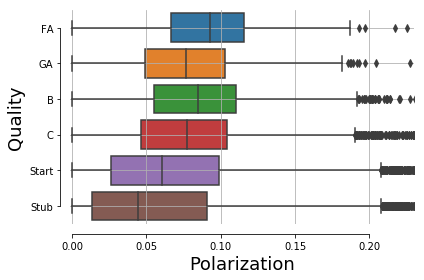

In [20]:
sns.boxplot(x='var_align', y='quality',data=sci_pages, order=['Stub','Start','C','B','GA','FA'][-1::-1], orient='h');
plt.xlabel('Polarization', fontsize=18);
plt.ylabel('Quality', fontsize=18);
plt.xlim([-0.001,0.23]);
plt.grid(True)
sns.despine(offset=10,trim=True);
plt.tight_layout();
# plt.savefig('science_quality.pdf');

In [21]:
%%R -i sci_pages
library(MASS)

sci_pages$quality=factor(sci_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~ abs(ave_align) + var_align + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = sci_pages, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

ctable <- cbind(ctable, "p value" = p, 'OR'=exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + scale(log(editors)) + 
    scale(log(length)) + scale(log(edits)) + scale(log(editscount)), 
    data = sci_pages, Hess = TRUE)

Coefficients:
                          Value Std. Error t value
abs(ave_align)         -0.42715    0.13835  -3.087
var_align               0.58265    0.21063   2.766
scale(log(editors))    -0.57339    0.03524 -16.272
scale(log(length))      4.03471    0.02671 151.072
scale(log(edits))       0.52314    0.03982  13.136
scale(log(editscount))  0.01097    0.01065   1.031

Intercepts:
           Value     Std. Error t value  
Stub|Start   -3.1004    0.0273  -113.5018
Start|C       1.0904    0.0235    46.4794
C|B           4.6849    0.0340   137.7326
B|GA          7.0614    0.0450   156.8531
GA|FA         8.5424    0.0552   154.6919

Residual Deviance: 75939.22 
AIC: 75961.22 
                             Value Std. Error     t value      p value
abs(ave_align)         -0.42715094 0.13834886   -3.087492 2

In [22]:
%%R -i sci_pages
library(MASS)

sci_pages$quality=factor(sci_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~ abs(ave_align) + var_align + I(var_align^2) + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = sci_pages, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

ctable <- cbind(ctable, "p value" = p, 'OR'=exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + I(var_align^2) + 
    scale(log(editors)) + scale(log(length)) + scale(log(edits)) + 
    scale(log(editscount)), data = sci_pages, Hess = TRUE)

Coefficients:
                           Value Std. Error  t value
abs(ave_align)         -0.467668    0.13905  -3.3633
var_align               1.874715    0.45316   4.1370
I(var_align^2)         -5.953430    1.85005  -3.2180
scale(log(editors))    -0.591123    0.03567 -16.5707
scale(log(length))      4.037092    0.02673 151.0498
scale(log(edits))       0.525171    0.03983  13.1844
scale(log(editscount))  0.008498    0.01068   0.7957

Intercepts:
           Value     Std. Error t value  
Stub|Start   -3.0587    0.0302  -101.2868
Start|C       1.1340    0.0271    41.7833
C|B           4.7287    0.0367   128.7944
B|GA          7.1044    0.0470   151.0208
GA|FA         8.5852    0.0569   150.9712

Residual Deviance: 75928.83 
AIC: 75952.83 
                              Value Std. Error

### Social Issue Articles

In [23]:
social_pages=pd.read_csv('Data/social_issue_pages.tsv',sep='\t',parse_dates=[1])
social_pages['time']=pd.to_datetime(social_pages['time'])
social_pages=social_pages.sort_values('time')

social_page_stats=social_pages.groupby('title').agg({'title':len, 'user':lambda x: x.nunique(), 'page_len':'last'})

social_page_stats.columns=['edits', 'editors', 'length']
social_page_stats=social_page_stats.reset_index()
social_page_stats['short']=social_page_stats['title'].str.replace(' ','').str.lower()
social_page_stats=social_page_stats.sort_values('length').drop_duplicates(subset='short', keep='last')

social_pages['byte']=social_pages[['title','page_len']].groupby('title').diff()['page_len'].fillna(social_pages['page_len'])
social_pages=social_pages[social_pages['byte']>0]
social_pages=social_pages.groupby(['title','user']).sum().reset_index()

social_pages=social_pages.merge(user_align,on='user')
social_pages=social_pages.merge(user_info2, how='inner', left_on='user', right_on='name')
social_pages=social_pages.dropna()
social_pages=social_pages.groupby('title').agg({'align':[np.mean,lambda x: np.var(x)], 'user':lambda x: x.nunique(), 'title':len, 'editcount':np.mean})
social_pages.columns=['ave_align','var_align','peditors','pedits','editscount']
social_pages=social_pages.reset_index()

social_pages=social_pages.merge(social_page_stats, how='inner', on='title')

social_quality=pd.read_csv('Data/social_issue_quality.tsv',sep='\t')
social_pages=social_pages.merge(social_quality,how='inner', on='title')

social_pages=social_pages.dropna()

In [24]:
social_page_stats.shape, social_pages.shape

((162085, 5), (161055, 11))

In [25]:
social_quality['quality'].value_counts()

Start    55884
C        48292
Stub     30853
B        14050
GA       10108
FA        3814
Name: quality, dtype: int64

In [26]:
social_page_stats.describe()

,edits,editors,length
count,162085.000000,162085.000000,162085.000000
mean,264.668433,121.797440,13152.758602
std,818.542165,336.536286,20847.338808
min,1.000000,1.000000,124.000000
25%,27.000000,15.000000,3129.000000
50%,63.000000,32.000000,6447.000000
75%,176.000000,86.000000,14088.000000
max,36613.000000,13305.000000,538466.000000


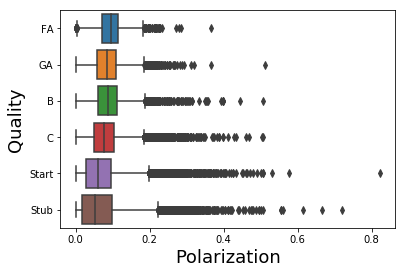

In [27]:
sns.boxplot(x='var_align', y='quality',data=social_pages, order=['Stub','Start','C','B','GA','FA'][-1::-1], orient='h');
plt.xlabel('Polarization', fontsize=18);
plt.ylabel('Quality', fontsize=18);

In [28]:
%%R -i social_pages
library(MASS)

social_pages$quality=factor(social_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~ abs(ave_align) + var_align + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = social_pages, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2
ctable <- cbind(ctable, "p value" = p, 'OR' = exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + scale(log(editors)) + 
    scale(log(length)) + scale(log(edits)) + scale(log(editscount)), 
    data = social_pages, Hess = TRUE)

Coefficients:
                          Value Std. Error t value
abs(ave_align)         -0.69825   0.082165  -8.498
var_align               0.73133   0.121673   6.011
scale(log(editors))    -0.66943   0.020470 -32.702
scale(log(length))      3.86699   0.014134 273.603
scale(log(edits))       0.53482   0.022977  23.276
scale(log(editscount))  0.05633   0.005746   9.804

Intercepts:
           Value     Std. Error t value  
Stub|Start   -3.8643    0.0166  -232.1487
Start|C       0.2631    0.0127    20.6827
C|B           4.3135    0.0185   233.2757
B|GA          5.9667    0.0219   272.7497
GA|FA         8.0753    0.0291   277.2197

Residual Deviance: 256435.23 
AIC: 256457.23 
                             Value  Std. Error     t value       p value
abs(ave_align)         -0.69825371 0.082165486   -8.

In [29]:
%%R -i social_pages
library(MASS)

social_pages$quality=factor(social_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~ abs(ave_align) + var_align + I(var_align^2) + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = social_pages, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2
ctable <- cbind(ctable, "p value" = p, 'OR' = exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + I(var_align^2) + 
    scale(log(editors)) + scale(log(length)) + scale(log(edits)) + 
    scale(log(editscount)), data = social_pages, Hess = TRUE)

Coefficients:
                           Value Std. Error t value
abs(ave_align)          -0.75855   0.082480  -9.197
var_align                3.44725   0.297662  11.581
I(var_align^2)         -13.21482   1.335772  -9.893
scale(log(editors))     -0.70124   0.020719 -33.846
scale(log(length))       3.87071   0.014147 273.606
scale(log(edits))        0.53834   0.022988  23.418
scale(log(editscount))   0.05121   0.005771   8.874

Intercepts:
           Value     Std. Error t value  
Stub|Start   -3.7749    0.0188  -200.6292
Start|C       0.3569    0.0158    22.6025
C|B           4.4085    0.0208   211.5649
B|GA          6.0611    0.0239   253.8425
GA|FA         8.1685    0.0306   266.7462

Residual Deviance: 256328.61 
AIC: 256352.61 
                             Value  Std. Error   

### Articles Combined

#### All 3 corpora

In [30]:
sci_pages['cat']='science'
sci_pages['cat2']=''
liberal_pages['cat']='politics'
liberal_pages['cat2']='liberal'
conservative_pages['cat']='politics'
conservative_pages['cat2']='conserv'
social_pages['cat']='social issue'
social_pages['cat2']=''

In [31]:
liberal_pages['title']=liberal_pages['title_x']
del liberal_pages['title_x']
del liberal_pages['title_y']

In [32]:
conservative_pages['title']=conservative_pages['title_x']
del conservative_pages['title_x']
del conservative_pages['title_y']

In [33]:
df_all=pd.concat([sci_pages,liberal_pages,conservative_pages,social_pages], ignore_index=True)

In [34]:
pearsonr(df_all['var_align'], np.log(df_all['editscount']+1))

(-0.07426896515993779, 2.1365957785369076e-270)

In [65]:
def colorify(y):
    if y<-0.96875: color='#001AE5'
    elif y<-0.9375: color='#0012E4'
    elif y<-0.90625: color='#000BE3'
    elif y<-0.875: color='#0004E3'
    elif y<-0.84375: color='#0200E2'
    elif y<-0.8125: color='#0900E1'
    elif y<-0.78125: color='#1100E1'
    elif y<-0.75: color='#1800E0'
    elif y<-0.71875: color='#1F00E0'
    elif y<-0.6875: color='#2600DF'
    elif y<-0.65625: color='#2D00DE'
    elif y<-0.625: color='#3300DE'
    elif y<-0.59375: color='#3A00DD'
    elif y<-0.5625: color='#4100DD'
    elif y<-0.53125: color='#4800DC'
    elif y<-0.5: color='#4F00DB'
    elif y<-0.46875: color='#5500DB'
    elif y<-0.4375: color='#5C00DA'
    elif y<-0.40625: color='#6300DA'
    elif y<-0.375: color='#6900D9'
    elif y<-0.34375: color='#7000D8'
    elif y<-0.3125: color='#7600D8'
    elif y<-0.28125: color='#7D00D7'
    elif y<-0.25: color='#8300D7'
    elif y<-0.21875: color='#8A00D6'
    elif y<-0.1875: color='#9000D5'
    elif y<-0.15625: color='#9600D5'
    elif y<-0.125: color='#9D00D4'
    elif y<-0.09375: color='#A300D4'
    elif y<-0.0625: color='#A900D3'
    elif y<-0.03125: color='#AF00D2'
    elif y<0.: color='#B500D2'
    elif y<0.03125: color='#BB00D1'
    elif y<0.0625: color='#C100D1'
    elif y<0.09375: color='#C800Cf'
    elif y<0.125: color='#CF00CA'
    elif y<0.15625: color='#CE00C3'
    elif y<0.1875: color='#CE00BC'
    elif y<0.21875: color='#CD00B5'
    elif y<0.25: color='#CC00AE'
    elif y<0.28125: color='#CC00A7'
    elif y<0.3125: color='#CB00A0'
    elif y<0.34375: color='#CB0099'
    elif y<0.375: color='#CA0092'
    elif y<0.40625: color='#C9008C'
    elif y<0.4375: color='#C90085'
    elif y<0.46875: color='#C8007E'
    elif y<0.5: color='#C80077'
    elif y<0.53125: color='#C70071'
    elif y<0.5625: color='#C6006A'
    elif y<0.59375: color='#C60063'
    elif y<0.625: color='#C5005D'
    elif y<0.65625: color='#C50056'
    elif y<0.6875: color='#C40050'
    elif y<0.71875: color='#C3004A'
    elif y<0.75: color='#C30043'
    elif y<0.78125: color='#C2003D'
    elif y<0.8125: color='#C20036'
    elif y<0.84375: color='#C10030'
    elif y<0.875: color='#C0002A'
    elif y<0.90625: color='#C00024'
    elif y<0.9375: color='#BF001E'
    else: color='#BF0018'
 
    return color

In [83]:
def downsample2d(x,y,logx=False,logy=False,width=500,height=500,weights=None):
    if logx:
        binx=np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),width)
    else:
        binx=width
    if logy:
        biny=np.logspace(np.log10(np.min(y)),np.log10(np.max(y)),height)
    else:
        biny=height

    z,binx2,biny2=np.histogram2d(x,y,bins=[binx, biny])
    xi,yi=z.nonzero()
    binx2=(binx2[:-1] + binx2[1:])/2
    biny2=(biny2[:-1] + biny2[1:])/2
    
    if weights is not None:
        z2,_,_=np.histogram2d(x,y,bins=[binx, biny],weights=weights)
        return binx2[xi],biny2[yi],z2[xi,yi]/z[xi,yi]
    
    return binx2[xi],biny2[yi]

In [67]:
x,y=downsample2d(df_all['editors'],df_all['ave_align'],logx=True,width=500,height=500)

In [68]:
c=map(colorify,y)

Correlation (0.042151521016916584, 2.0501021388378951e-153)


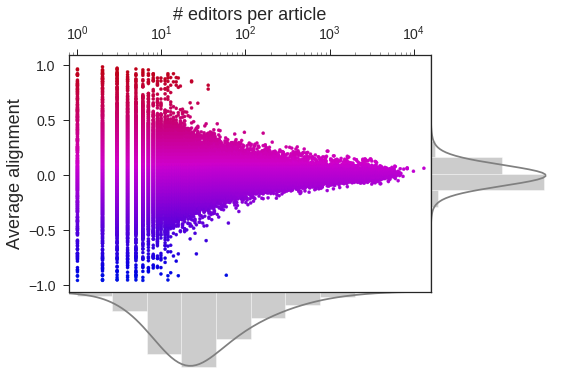

In [69]:
sns.set(style="ticks", palette="muted", color_codes=True)
gs = gridspec.GridSpec(4, 4)
histax=plt.subplot(gs[-1,:-1])
mainax=plt.subplot(gs[0:-1,:-1])
histax2=plt.subplot(gs[0:-1,-1])
gs.update(hspace=0, wspace=0)

mainax.scatter(x,y,s=10,c=c);
mainax.set_xscale('log')
mainax.set_xlim([10**(-0.1),10**4.2])
mainax.set_xlabel('# editors per article', fontsize=18);
mainax.set_ylabel('Average alignment', fontsize=18);
mainax.xaxis.set_tick_params(which='major', labelsize=14)
mainax.yaxis.set_tick_params(which='major', labelsize=14)
mainax.yaxis.set_major_locator(MaxNLocator(5))
mainax.xaxis.set_label_position('top')
mainax.xaxis.tick_top()

sns.distplot(np.log10(df_all.editors), bins=10, norm_hist=False, color='grey',hist_kws={'log':False, 'edgecolor':"w", 'lw':1},kde_kws={'bw':0.2},ax=histax);
histax.set_xlim([-0.1,4.2])
histax.xaxis.set_major_formatter(NullFormatter());
sns.despine(left=True,bottom=True,ax=histax);
histax.set_yticks([]);
histax.set_xticks([]);
histax.set_xlabel('');
histax.invert_yaxis()

sns.distplot(df_all.ave_align, bins=10, norm_hist=False, color='grey', hist_kws={'edgecolor':"w", 'lw':1},kde_kws={'bw':.1},ax=histax2,vertical=True);
histax2.yaxis.set_major_formatter(NullFormatter());
sns.despine(bottom=True,ax=histax2);
histax2.set_yticks([]);
histax2.set_xticks([]);
histax2.set_ylabel('');

plt.tight_layout()
# plt.savefig('article_align3.pdf');
print "Correlation {}".format(pearsonr(np.log(df_all.editors),df_all.ave_align))

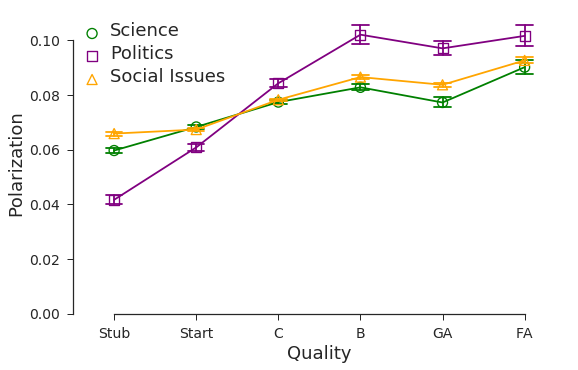

In [31]:
sns.set(style="ticks",rc={"lines.linewidth": 1})
plt.figure(figsize=[8.2,5.3])
ax=sns.pointplot(x='quality', y='var_align', hue='cat', data=df_all,
              order=['Stub','Start','C','B','GA','FA'], ci=95,
              join=True, capsize=0.2, markers=['o','s','^'],
              palette={"politics": "purple", "science": "green", "social issue":'orange'});
plt.setp(ax.collections, sizes=[100])
plt.setp(ax.collections, facecolor='none')
plt.ylim([0,0.11])
leg=plt.legend()
leg.texts[0].set_text('Science');
leg.texts[0].set_fontsize(18)
leg.texts[1].set_text('Politics');
leg.texts[1].set_fontsize(18);
leg.texts[2].set_text('Social Issues');
leg.texts[2].set_fontsize(18);
plt.xlabel('Quality', fontsize=18);
plt.ylabel('Polarization', fontsize=18);
plt.tick_params(which='major', labelsize=14)
sns.despine(offset=0,trim=True);
plt.tight_layout();
#plt.savefig('mean_quality4.pdf');

#### Politics

In [35]:
df_poli=df_all[df_all['cat']=='politics']

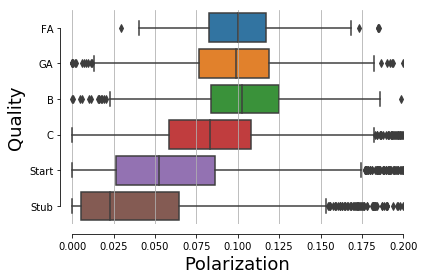

In [36]:
sns.boxplot(x='var_align', y='quality',data=df_poli, order=['Stub','Start','C','B','GA','FA'][-1::-1], orient='h');
plt.xlabel('Polarization', fontsize=18);
plt.ylabel('Quality', fontsize=18);
plt.xlim([-0.001,0.2]);
plt.grid(axis='x')
sns.despine(offset=10,trim=True);
plt.tight_layout();
# plt.savefig('political_quality.pdf');

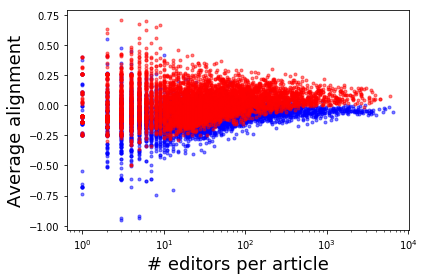

In [37]:
plt.plot(df_poli.loc[df_poli.cat2=='liberal','editors'], df_poli.loc[df_poli.cat2=='liberal','ave_align'], '.', color='blue', alpha=0.5);
plt.plot(df_poli.loc[df_poli.cat2=='conserv','editors'], df_poli.loc[df_poli.cat2=='conserv','ave_align'], '.', color='red', alpha=0.5);
plt.xscale('log')
plt.xlabel('# editors per article',fontsize=18);
plt.ylabel('Average alignment',fontsize=18);
plt.tight_layout();
#plt.savefig('political_article_align.pdf')

In [38]:
%%R -i df_poli
library(MASS)

df_poli$quality=factor(df_poli$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~  abs(ave_align) + var_align + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = df_poli, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2
ctable <- cbind(ctable, "p value" = p, "OR"=exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + scale(log(editors)) + 
    scale(log(length)) + scale(log(edits)) + scale(log(editscount)), 
    data = df_poli, Hess = TRUE)

Coefficients:
                          Value Std. Error t value
abs(ave_align)         -1.18548    0.27243  -4.352
var_align               2.93448    0.48742   6.020
scale(log(editors))    -0.89666    0.08705 -10.300
scale(log(length))      3.51284    0.05258  66.815
scale(log(edits))       1.18210    0.09844  12.009
scale(log(editscount))  0.04878    0.02176   2.242

Intercepts:
           Value    Std. Error t value 
Stub|Start  -3.1319   0.0570   -54.9857
Start|C      1.0169   0.0518    19.6407
C|B          5.6195   0.0869    64.6627
B|GA         6.5620   0.0938    69.9832
GA|FA        9.8632   0.1461    67.4993

Residual Deviance: 18440.50 
AIC: 18462.50 
                             Value Std. Error    t value      p value
abs(ave_align)         -1.18547799 0.27242620  -4.351556 1.351745e-05
var_

In [39]:
%%R -i df_poli
library(MASS)

df_poli$quality=factor(df_poli$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
m <- polr(quality ~  abs(ave_align) + var_align + I(var_align^2) + scale(log(editors)) + scale(log(length)) + scale(log(edits)) + scale(log(editscount)), data = df_poli, Hess=TRUE)

ctable <- coef(summary(m))
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2
ctable <- cbind(ctable, "p value" = p, "OR"=exp(coef(m)))
print(summary(m))
print(ctable)

Call:
polr(formula = quality ~ abs(ave_align) + var_align + I(var_align^2) + 
    scale(log(editors)) + scale(log(length)) + scale(log(edits)) + 
    scale(log(editscount)), data = df_poli, Hess = TRUE)

Coefficients:
                           Value Std. Error t value
abs(ave_align)          -1.10646    0.27202  -4.068
var_align                9.80206    1.29166   7.589
I(var_align^2)         -35.21436    6.20485  -5.675
scale(log(editors))     -0.94588    0.08759 -10.799
scale(log(length))       3.52848    0.05171  68.239
scale(log(edits))        1.15130    0.09808  11.738
scale(log(editscount))   0.03671    0.02176   1.687

Intercepts:
           Value    Std. Error t value 
Stub|Start  -2.9138   0.0696   -41.8365
Start|C      1.2593   0.0661    19.0473
C|B          5.8568   0.0934    62.6994
B|GA         6.7954   0.0992    68.4779
GA|FA       10.0805   0.1466    68.7594

Residual Deviance: 18408.94 
AIC: 18432.94 
                             Value Std. Error    t value      p valu

### Talk Pages

#### Number of edits

In [40]:
talk_pages=pd.read_csv('Data/talk_pages.tsv',sep='\t',parse_dates=[1])

In [41]:
talk_pages=talk_pages.sort_values('time')
talk_page_stats=talk_pages.groupby('title').agg({'title':len, 'user':lambda x: x.nunique(), 'page_len':'last'})
talk_page_stats.columns=['edits', 'editors', 'length']

talk_page_stats=talk_page_stats.reset_index()
talk_page_stats['short']=talk_page_stats['title'].str.replace(' ','').str.lower()
talk_page_stats=talk_page_stats.sort_values('length').drop_duplicates(subset='short', keep='last')

talk_pages=talk_page_stats.merge(df_all,on='title',how='inner')

In [42]:
talk_page_stats.shape, talk_pages.shape

((319514, 5), (206818, 17))

In [44]:
m=sm.ols('np.log(edits_x) ~  var_align + np.log(editors_x) + np.log(length_x+1) + np.log(length_y)', data = talk_pages).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(edits_x)   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 1.018e+06
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:45:54   Log-Likelihood:                -53815.
No. Observations:              206818   AIC:                         1.076e+05
Df Residuals:                  206813   BIC:                         1.077e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7937      0.006   -125.744      0.000      -0.806      -0.781
var_align                0.1075      0.015      7.326      0.000       0.079       0.136
np.log(editors_x)        1.0330      0.001    983.495      0.000       1.031       1.035
np.log(length_x + 1)     0.0913      0.001    154.033      0.000       0.090       0.092
np.log(length_y)         0.0489      0.001     60.847      0.000       0.047       0.051
==============================================================================
Omnibus:                    92777.183   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           629444.850
Skew:                           2.049   Prob(JB):                         0.00
Kurtosis:                      10.500   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### TF-IDF score

In [46]:
tfidf=pd.read_csv('Data/talk_page_tfidf.tsv', sep='\t')
talk_pages=talk_pages.merge(tfidf, on='title')

In [47]:
tfidf=pd.read_csv('Data/article_tfidf.tsv', sep='\t')
del tfidf['id']
tfidf.columns=['article_tfidf','title']
talk_pages=talk_pages.merge(tfidf, on='title')

In [50]:
m = sm.ols('np.log(tfidf)-np.log(length_x+1) ~ var_align + np.log(editors_x) + np.log(edits_x) + np.log(article_tfidf/length_y)', data = talk_pages).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(tfidf)   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                 1.100e+05
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:50:38   Log-Likelihood:            -3.4776e+05
No. Observations:              206256   AIC:                         6.955e+05
Df Residuals:                  206251   BIC:                         6.956e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            2.7665      0.017    158.630      0.000       2.732       2.801
var_align                            1.4009      0.061     22.866      0.000       1.281       1.521
np.log(editors_x)                   -0.0902      0.010     -8.650      0.000      -0.111      -0.070
np.log(edits_x)                      1.3932      0.008    164.063      0.000       1.377       1.410
np.log(article_tfidf / length_y)     0.1127      0.017      6.809      0.000       0.080       0.145
==============================================================================
Omnibus:                     5573.280   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6353.241
Skew:                          -0.374   Prob(JB):                         0.00
Kurtosis:                       3.422   Cond. No.                         73.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Word Radius

In [52]:
embedr=pd.read_csv('Data/talk_page_radius.tsv', sep='\t')
talk_pages=talk_pages.merge(embedr[['radius','title']], on='title')

In [53]:
embedr=pd.read_csv('Data/article_radius.tsv', sep='\t')
embedr.columns=[u'title', u'words', u'article_radius']
talk_pages=talk_pages.merge(embedr[['article_radius','title']], on='title')

In [54]:
m = sm.ols('radius ~ var_align + np.log(editors_x) + np.log(edits_x) + article_radius', data = talk_pages).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 radius   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                 1.368e+04
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:52:51   Log-Likelihood:                -83286.
No. Observations:              205744   AIC:                         1.666e+05
Df Residuals:                  205739   BIC:                         1.666e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4838      0.010    238.080      0.000       2.463       2.504
var_align            -0.4431      0.017    -25.997      0.000      -0.476      -0.410
np.log(editors_x)     0.1510      0.003     52.145      0.000       0.145       0.157
np.log(edits_x)      -0.2125      0.002    -90.069      0.000      -0.217      -0.208
article_radius        0.3415      0.003    126.225      0.000       0.336       0.347
==============================================================================
Omnibus:                    62295.642   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           780481.499
Skew:                          -1.102   Prob(JB):                         0.00
Kurtosis:                      12.283   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Agressiveness

In [55]:
attack=pd.read_csv('Data/talk_page_attack.tsv', sep='\t')

In [56]:
talk_pages=talk_pages.merge(attack, on='title', how='left')

In [57]:
m=sm.ols('np.log(attack) ~  var_align + np.log(editors_x) + np.log(edits_x) + np.log(length_x+1) + np.log(length_y)', data=talk_pages).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(attack)   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     8223.
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:53:43   Log-Likelihood:            -2.2363e+05
No. Observations:              205744   AIC:                         4.473e+05
Df Residuals:                  205738   BIC:                         4.473e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.6980      0.015   -244.088      0.000      -3.728      -3.668
var_align               -0.1727      0.034     -5.121      0.000      -0.239      -0.107
np.log(editors_x)        0.2458      0.006     42.879      0.000       0.235       0.257
np.log(edits_x)         -0.0285      0.005     -5.646      0.000      -0.038      -0.019
np.log(length_x + 1)    -0.2078      0.001   -141.486      0.000      -0.211      -0.205
np.log(length_y)        -0.0894      0.002    -47.691      0.000      -0.093      -0.086
==============================================================================
Omnibus:                    24419.925   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133756.670
Skew:                           0.447   Prob(JB):                         0.00
Kurtosis:                       6.848   Cond. No.                         248.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
m=sm.ols('np.log(attack) ~  np.abs(ave_align) + var_align + np.log(editors_x) + np.log(edits_x) + np.log(length_x+1) + np.log(length_y)', data=talk_pages).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(attack)   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     6855.
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:24:42   Log-Likelihood:            -2.2362e+05
No. Observations:              205744   AIC:                         4.473e+05
Df Residuals:                  205737   BIC:                         4.473e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.7105      0.016   -238.959      0.000      -3.741      -3.680
np.abs(ave_align)        0.0821      0.022      3.671      0.000       0.038       0.126
var_align               -0.1889      0.034     -5.554      0.000      -0.256      -0.122
np.log(editors_x)        0.2482      0.006     43.021      0.000       0.237       0.259
np.log(edits_x)         -0.0295      0.005     -5.840      0.000      -0.039      -0.020
np.log(length_x + 1)    -0.2076      0.001   -141.238      0.000      -0.211      -0.205
np.log(length_y)        -0.0889      0.002    -47.304      0.000      -0.093      -0.085
==============================================================================
Omnibus:                    24415.459   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133773.024
Skew:                           0.446   Prob(JB):                         0.00
Kurtosis:                       6.848   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Policy Mention

In [59]:
policies=pd.read_csv('Data/talk_page_policy.tsv',sep='\t')

In [60]:
df=policies.groupby('title').sum()
df=df.reset_index()
df.columns=['title','all_policy']
talk_pages=talk_pages.merge(df, on='title', how='left')

In [61]:
m=sm.ols('np.log(all_policy) ~  var_align + np.log(editors_x) + np.log(edits_x) + np.log(length_x+1) + np.log(length_y)', data=talk_pages).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(all_policy)   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     2163.
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:26:10   Log-Likelihood:                -32042.
No. Observations:               26938   AIC:                         6.410e+04
Df Residuals:                   26932   BIC:                         6.415e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.7721      0.063    -27.994      0.000      -1.896      -1.648
var_align                0.5658      0.143      3.965      0.000       0.286       0.845
np.log(editors_x)       -0.3566      0.013    -28.078      0.000      -0.382      -0.332
np.log(edits_x)          0.2959      0.011     26.459      0.000       0.274       0.318
np.log(length_x + 1)     0.3669      0.006     59.043      0.000       0.355       0.379
np.log(length_y)        -0.0673      0.006    -10.873      0.000      -0.079      -0.055
==============================================================================
Omnibus:                      312.867   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.273
Skew:                           0.137   Prob(JB):                     8.15e-52
Kurtosis:                       2.633   Cond. No.                         433.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
x='''WP:ADMIN, WP:SYSOP, WP:MOP
WP:AAB, WP:APPEAL
WP:AT, WP:TITLE
WP:BAN
WP:BP, WP:BLOCK
WP:BOTPOL
WP:CON, WP:CONS
WP:CSD
WP:CIVIL
WP:C, WP:COPY
WP:DP, WP:DEL, WP:DELETE
WP:DR
WP:EP
WP:EW, WP:WAR
WP:HA
WP:IAR
WP:EXEMPT, WP:IPEXEMPT, WP:IPBE
WP:IUP
WP:LOP
WP:NPOV, WP:NEU
WP:NLT, WP:LEGAL, WP:THREAT
WP:NOR, WP:OR
WP:NPA, WP:PA
WP:OWN
WP:POLICY, WP:RULES
WP:PROD
WP:SOCK
WP:NIU, WP:NOU, WP:U, WP:UN
WP:VAND, WP:VANDAL, WP:-(
WP:V, WP:VERIFY
WP:NOT, WP:WWIN, WP:WWPIN, WP:ISNOT, WP:ALSONOT
WP:ENC
WP:WINAD, WP:DICDEF'''

x=[i.strip(',') for i in x.split()]

df=policies[policies['policy'].isin(x)].groupby('title').sum()
df=df.reset_index()
df.columns=['title','policy']
talk_pages=talk_pages.merge(df, on='title', how='left')

In [63]:
m=sm.ols('np.log(policy+1) ~  var_align + np.log(editors_x) + np.log(edits_x) + np.log(length_x+1) + np.log(length_y)', data=talk_pages.fillna(0)).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(policy + 1)   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                 1.535e+04
Date:                Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:26:53   Log-Likelihood:                -75675.
No. Observations:              205744   AIC:                         1.514e+05
Df Residuals:                  205738   BIC:                         1.514e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2845      0.007    -38.542      0.000      -0.299      -0.270
var_align                0.0529      0.016      3.220      0.001       0.021       0.085
np.log(editors_x)       -0.2813      0.003   -100.739      0.000      -0.287      -0.276
np.log(edits_x)          0.2964      0.002    120.457      0.000       0.292       0.301
np.log(length_x + 1)     0.0527      0.001     73.616      0.000       0.051       0.054
np.log(length_y)        -0.0075      0.001     -8.158      0.000      -0.009      -0.006
==============================================================================
Omnibus:                   124844.245   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1658738.125
Skew:                           2.719   Prob(JB):                         0.00
Kurtosis:                      15.803   Cond. No.                         248.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
x='''WP:LGL, WP:LOGL, WP:GUIDELINES
WP:AGF, WP:ASG, WP:AFG, WP:GF, WP:FAITH
WP:BB, WP:BBIUP, WP:BBIEP, WP:BOLD, WP:SOFIXIT
WP:LIVING, WP:BLP
WP:CLS, WP:CSL
WP:CG, WP:CAT
WP:CITE, WP:REF
WP:CK, WP:COMKNOW
WP:COI
WP:DGFA
WP:D, WP:DAB, WP:DISAM, WP:DISAMBIG
WP:DE, WP:DISRUPT
WP:POINT
WP:EL, WP:EXT
WP:LOGOS, WP:LOGO
WP:L&P
WP:READERS
WP:MOS, WP:STYLE, MOS:
WP:ABB, WP:ABBR, MOS:ABB
WP:MOSBIO, WP:NAMES, MOS:BIO
WP:MOS-ZH
WP:MOSDATE, WP:MOSNUM, WP:DATE, WP:MOSNUM, MOS:DATE, MOS:NUM
WP:MOSDAB, WP:MOSDP, MOS:DAB, MOS:DP
WP:IMOS, WP:MOS-IR
WP:MOS-JA, WP:MOS-JP, WP:MJ
WP:MOS-KO
WP:GTL, WP:LAY, WP:LAYOUT
WP:LEAD, WP:LS
WP:MOS-L, MOS:L
WP:L, WP:LIST, WP:LISTS
WP:MSM, WP:MOS-MATH, MOS:MATH
WP:MOS-P, WP:MOSIPA, WP:PRON
WP:SRTA, WP:SELF
WP:HTUT
WP:MOS-T, MOS:T
WP:MOS-TM, WP:MOSTM, MOS:TM
WP:WAF
WP:NC-ZH
WP:N
WP:FICT
WP:MUSIC, WP:MUS, WP:NMG
WP:CORP, WP:ORG
WP:WEB
WP:ROWN
WP:SIG, WP:SIGNATURE, WP:SIGN
WP:NOSPAM, WP:SPAM
WP:SK
WP:SPOIL, WP:SPOILER, WP:SW
WP:STUB
WP:SP, WP:SUBP, WP:SUBPAGE, WP:SUBPAGES, WP:DNUS
WP:DISCUSSION, WP:TALK, WP:TPG
WP:TPT
WP:3O, WP:30, WP:THIRD, WP:RF3O
WP:SISTER, WP:SIS, WP:MOSSIS'''

x=[i.strip(',') for i in x.split()]

df=policies[policies['policy'].isin(x)].groupby('title').sum()
df=df.reset_index()
df.columns=['title','guideline']

talk_pages=talk_pages.merge(df, on='title', how='left')

In [66]:
m=sm.ols('np.log(guideline+1) ~ var_align + np.log(editors_x) + np.log(edits_x) + np.log(length_x+1) + np.log(length_y)', data=talk_pages.fillna(0)).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(guideline + 1)   R-squared:                       0.264
Model:                               OLS   Adj. R-squared:                  0.264
Method:                    Least Squares   F-statistic:                 1.473e+04
Date:                   Sun, 03 Mar 2019   Prob (F-statistic):               0.00
Time:                           21:28:04   Log-Likelihood:                -68463.
No. Observations:                 205744   AIC:                         1.369e+05
Df Residuals:                     205738   BIC:                         1.370e+05
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.3058      0.007    -42.914      0.000      -0.320      -0.292
var_align                0.0825      0.016      5.199      0.000       0.051       0.114
np.log(editors_x)       -0.2473      0.003    -91.709      0.000      -0.253      -0.242
np.log(edits_x)          0.2607      0.002    109.703      0.000       0.256       0.265
np.log(length_x + 1)     0.0529      0.001     76.609      0.000       0.052       0.054
np.log(length_y)        -0.0040      0.001     -4.580      0.000      -0.006      -0.002
==============================================================================
Omnibus:                   124024.584   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1641685.722
Skew:                           2.696   Prob(JB):                         0.00
Kurtosis:                      15.745   Cond. No.                         248.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Correlation

In [67]:
talk_pages.describe(include='all')

,title,edits_x,editors_x,length_x,short_x,ave_align,cat,cat2,editors_y,edits_y,editscount,length_y,peditors,pedits,quality,short_y,var_align,tfidf,article_tfidf,radius,article_radius,attack,aggressive,all_policy,policy,guideline
count,205744,205744.000000,205744.000000,205744.000000,205744,205744.000000,205744,205744,205744.000000,205744.000000,2.057440e+05,205744.000000,205744.000000,205744.000000,205744,205744,205744.000000,205744.000000,205744.000000,205744.000000,205744.000000,205744.000000,205744.000000,26938.000000,19470.000000,20398.000000
unique,194473,NaN,NaN,NaN,194473,NaN,3,3,NaN,NaN,NaN,NaN,NaN,NaN,6,194473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Paul Krugman,NaN,NaN,NaN,virginiaabernethy,NaN,social issue,,NaN,NaN,NaN,NaN,NaN,NaN,Start,virginiaabernethy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,NaN,NaN,3,NaN,149216,193567,NaN,NaN,NaN,NaN,NaN,NaN,70187,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,42.607741,14.259711,4943.420873,NaN,-0.006196,NaN,NaN,124.469579,267.254282,4.961613e+05,13088.262365,32.897713,32.898383,NaN,NaN,0.074130,2162.202250,5050.308942,3.556069,3.737795,0.006408,0.006717,5.101307,3.434874,3.010393
std,NaN,368.847557,52.505261,13238.088739,NaN,0.103358,NaN,NaN,336.582261,809.068986,4.016236e+05,20315.121023,71.007106,71.009537,NaN,NaN,0.048733,5940.515027,8171.478887,0.408105,0.297807,0.016011,0.019650,7.628744,4.636773,4.108208
min,NaN,1.000000,1.000000,2.000000,NaN,-0.962408,NaN,NaN,1.000000,1.000000,4.200000e+01,21.000000,1.000000,1.000000,NaN,NaN,0.000000,0.799167,50.721086,0.000000,0.557641,0.000026,0.000045,1.000000,1.000000,1.000000
25%,NaN,3.000000,3.000000,134.000000,NaN,-0.057973,NaN,NaN,16.000000,29.000000,2.339372e+05,3114.000000,7.000000,7.000000,NaN,NaN,0.037398,33.577067,1149.115497,3.227211,3.539056,0.002515,0.002775,1.000000,1.000000,1.000000
50%,NaN,6.000000,5.000000,623.000000,NaN,-0.006318,NaN,NaN,34.000000,65.000000,3.997730e+05,6464.000000,14.000000,14.000000,NaN,NaN,0.071544,237.011592,2436.556834,3.595653,3.740243,0.003996,0.004174,3.000000,2.000000,2.000000
75%,NaN,15.000000,11.000000,3228.000000,NaN,0.042968,NaN,NaN,89.000000,181.000000,6.485338e+05,14220.000000,30.000000,30.000000,NaN,NaN,0.103207,1357.113460,5453.994526,3.889960,3.946466,0.006179,0.006432,5.000000,4.000000,3.000000


In [68]:
df=talk_pages[['var_align','tfidf','radius','policy','guideline']]

In [69]:
df.columns=['polarization','lexical div.','semantic div.','policy','guideline']

In [70]:
df.loc[:,'quality']=pd.Categorical(talk_pages['quality'], categories=["Stub", "Start", "C", "B", "GA", 'FA'], ordered=True);

/home/bill10/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bill10/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [71]:
df.loc[:,'quality']=df['quality'].cat.codes;

/home/bill10/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [72]:
df.loc[:,'talk length']=talk_pages['length_x'];
df.loc[:,'talk editors']=talk_pages['editors_x'];
df.loc[:,'talk edits']=talk_pages['edits_x'];
df.loc[:,'article length']=talk_pages['length_y'];
df.loc[:,'article editors']=talk_pages['editors_y'];
df.loc[:,'article edits']=talk_pages['edits_y'];
df.loc[:,'temperature']=talk_pages['attack'];

/home/bill10/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bill10/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
df.loc[:,'lexical div.']=np.log(df['lexical div.'])-np.log(df['talk length'])

/home/bill10/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
df=df[['polarization', 'lexical div.','semantic div.', u'policy', u'guideline','temperature', u'talk length', u'talk editors',
       u'talk edits', u'article length', u'article editors', u'article edits','quality']]

In [75]:
corr=df.corr()

/home/bill10/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


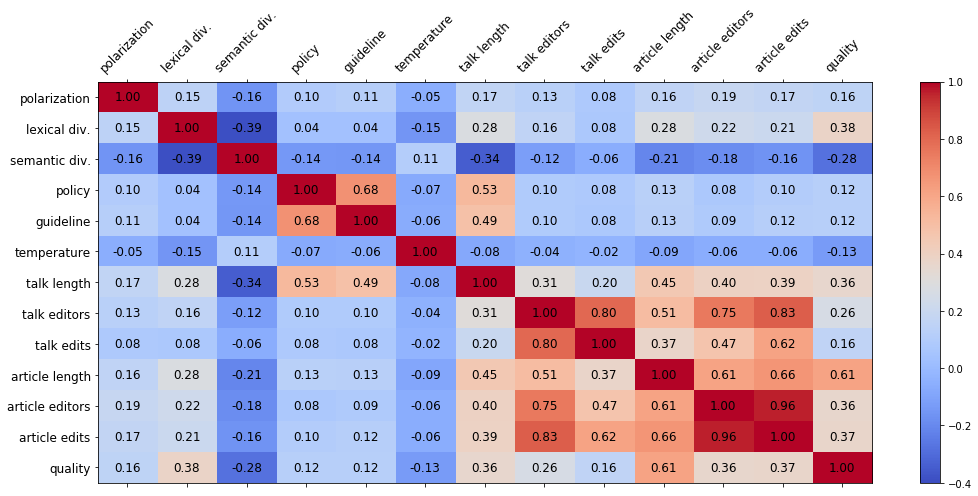

In [77]:
fig,ax=plt.subplots(figsize=(15,7))
p=ax.matshow(corr, cmap='coolwarm',aspect='auto',vmin=-0.4, vmax=1)
plt.yticks(range(len(corr)), corr.index.tolist(),fontsize=12);
plt.xticks(range(len(corr)), corr.index.tolist(),fontsize=12, rotation=45);
plt.grid('off');
cb=plt.colorbar(p);
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=12)
plt.tight_layout()
#plt.savefig('correlation.pdf');

### Structural equation modeling

In [78]:
%%R -i talk_pages

library('lavaan')

talk_pages[is.na(talk_pages)]=NA

talk_pages$quality=factor(talk_pages$quality, levels=c("Stub", "Start", "C", "B", "GA", 'FA'), ordered=T)
talk_pages$ave_align=abs(talk_pages$ave_align)
talk_pages$article_editors=log(talk_pages$editors_y)
talk_pages$article_length=log(talk_pages$length_y)
talk_pages$article_edits=log(talk_pages$edits_y)
talk_pages$preedits=log(talk_pages$editscount)
talk_pages$talk_edits=log(talk_pages$edits_x)
talk_pages$talk_editors=log(talk_pages$editors_x)
talk_pages$talk_length=log(talk_pages$length_x)
talk_pages$talk_tfidf=log(talk_pages$tfidf)-log(talk_pages$length_x)
talk_pages$article_tfidf=log(talk_pages$article_tfidf)-log(talk_pages$length_y)
talk_pages$talk_radius=talk_pages$radius
talk_pages$policy[is.na(talk_pages$policy)]=0
talk_pages$policy=log(talk_pages$policy+1)
talk_pages$guideline[is.na(talk_pages$guideline)]=0
talk_pages$guideline=log(talk_pages$guideline+1)
talk_pages$aggressive=log(talk_pages$attack)

/home/bill10/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: This is lavaan 0.5-23.1097

  warnings.warn(x, RRuntimeWarning)
/home/bill10/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: lavaan is BETA software! Please report any bugs.

  warnings.warn(x, RRuntimeWarning)


In [79]:
%%R

model <- ' # latent variable definitions
             volume =~ talk_edits + talk_length
             institution =~ policy + guideline
             article_activity =~ article_editors + article_length + article_edits
           # direct effect
             quality ~ ave_align + preedits + article_activity + d1*volume + d2*talk_tfidf + d25*talk_radius +d3*institution + d4*aggressive
           # mediator
             volume ~ m1*var_align + talk_editors
             talk_tfidf ~ m2*var_align + talk_editors
             talk_radius ~ m25*var_align + talk_editors
             institution ~ m3*var_align + talk_editors
             aggressive  ~  m4*var_align + talk_editors
           # covariance
           #  article_activity  ~ volume
           # Effects
             volumee:=d1*m1
             lexi:=d2*m2
             seman:=d25*m25
             institutione:=d3*m3
             heat:=d4*m4
             totale:= volumee+lexi+seman+heat+institutione
'

fit <- sem(model, data = talk_pages)

In [80]:
%%R
summary(fit)

lavaan (0.5-23.1097) converged normally after 123 iterations

  Number of observations                        205744

  Estimator                                       DWLS      Robust
  Minimum Function Test Statistic           1434575.278  967954.785
  Degrees of freedom                                74          74
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.482
  Shift parameter                                           26.179
    for simple second-order correction (Mplus variant)

Parameter Estimates:

  Information                                 Expected
  Standard Errors                           Robust.sem

Latent Variables:
                      Estimate  Std.Err  z-value  P(>|z|)
  volume =~                                              
    talk_edits           1.000                           
    talk_length          1.152    0.002  605.543    0.000
  institution =~                        